In [ ]:
! pip install fast-tabnet


In [ ]:
from fastai.basics import *
from fastai.tabular.all import *
from fast_tabnet.core import *

In [ ]:
import numpy as np
import torch
import random
import fastai

# Set random seeds for reproducibility set to control the randomness of the code
SEED = 42
set_seed(SEED, reproducible=True)


In [ ]:
#Selects thw 1st 1000 th row for train and the last 1000 th row for test
import pandas as pd
df = pd.read_csv('/content/autism_final - Sheet1.csv' )
df=df.replace(to_replace="?",value="unknown")
train_size = int(0.8 * len(df))
df_main, df_test = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

In [ ]:
#Handling categorical values like taking text featues converting them to numeric handling missing values and scaling it
cont_names = ['A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score','A9_Score','A10_Score','result']
cat_names = ['gender','contry_of_res','ethnicity','relation','jundice','austim']
procs = [Categorify,FillMissing, Normalize]
#splits = RandomSplitter(seed=SEED)(range_of(df_main)) #use the indices of df_main to split the entire dataset

In [ ]:
#split data into train and validation
splits = RandomSplitter(valid_pct=0.1,seed=SEED)(range_of(df_main))

In [ ]:
# it is used to load data apply all the preprocessing steps to it and data and define dataloaders for the train and test
#dataloaders act like iterators to provide data in batches during training
y_names='Class/ASD'


X=df[cont_names+cat_names]
to = TabularPandas(df, procs=[Categorify,FillMissing, Normalize],
                   cat_names=cat_names,
                   cont_names=cont_names,
                   y_names=y_names,
                   splits=splits)
dls = to.dataloaders(bs=32)

to_tst = to.new(df_test)
to_tst.process()
to_tst.all_cols.head()

,gender,contry_of_res,ethnicity,relation,jundice,austim,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,Class/ASD
880,2,41,6,5,1,1,0.687109,-0.938741,0.883049,0.945905,-1.220887,-0.967693,1.046536,0.819076,-0.83205,-1.270378,-0.166528,0
881,2,49,12,7,1,1,-1.455373,1.065256,-1.132440,-1.057188,-1.220887,-0.967693,-0.955533,0.819076,1.20185,-1.270378,-0.956292,0
882,2,86,10,5,1,1,0.687109,1.065256,0.883049,0.945905,0.819076,1.033385,1.046536,-1.220887,1.20185,0.787167,1.412999,1
883,1,87,10,5,1,1,0.687109,1.065256,-1.132440,0.945905,0.819076,1.033385,-0.955533,-1.220887,1.20185,0.787167,0.623235,1
884,2,62,2,5,1,1,-1.455373,1.065256,0.883049,-1.057188,-1.220887,-0.967693,1.046536,-1.220887,-0.83205,0.787167,-0.561410,0


In [ ]:
#how big to make the categorical embeddings
emb_szs = get_emb_sz(to)
#early_stopping = EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=3)

In [ ]:
#define the TabNet model and set all the parameters
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=8, n_steps=5, mask_type='entmax');

In [ ]:
#compilation
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=partial(Adam), lr=3e-2, metrics=[accuracy])


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.007585775572806597)

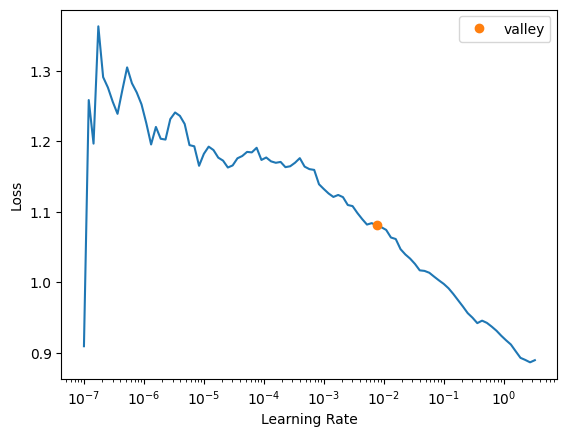

In [ ]:
#finding the learning rate
learn.lr_find()

In [ ]:

# Add early stopping
#early_stopping = SaveModelCallback(monitor='valid_loss', comp=np.less, min_delta=0.01)

learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.954533,0.730058,0.375000,00:01
1,0.787269,0.672913,0.704545,00:01
2,0.705347,0.610359,0.647727,00:01
3,0.645184,0.488529,0.886364,00:04
4,0.566065,0.313109,0.840909,00:03
5,0.491123,0.208927,0.909091,00:02
6,0.406570,0.254053,0.840909,00:02
7,0.343288,0.150717,0.943182,00:02
8,0.293448,0.176297,0.897727,00:03
9,0.266987,0.156083,0.965909,00:04


In [ ]:
learn.show_results()

,gender,contry_of_res,ethnicity,relation,jundice,austim,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,Class/ASD,Class/ASD_pred
0,1.0,60.0,10.0,3.0,1.0,1.0,0.687109,1.065256,0.883049,0.945905,0.819076,-0.967693,1.046536,-1.220887,1.20185,0.787167,1.018117,1.0,0.0
1,2.0,9.0,10.0,3.0,1.0,1.0,0.687109,-0.938741,0.883049,0.945905,0.819076,1.033385,1.046536,0.819076,1.20185,-1.270378,1.018117,1.0,1.0
2,1.0,86.0,1.0,3.0,2.0,1.0,-1.455373,-0.938741,0.883049,-1.057188,0.819076,1.033385,1.046536,0.819076,1.20185,0.787167,0.623235,1.0,1.0
3,1.0,85.0,9.0,5.0,1.0,1.0,0.687109,1.065256,-1.132440,-1.057188,-1.220887,-0.967693,-0.955533,0.819076,-0.83205,-1.270378,-0.956292,0.0,0.0
4,2.0,87.0,6.0,5.0,2.0,1.0,0.687109,1.065256,0.883049,0.945905,0.819076,-0.967693,1.046536,0.819076,1.20185,0.787167,1.412999,1.0,1.0
5,2.0,86.0,10.0,5.0,2.0,1.0,0.687109,1.065256,0.883049,-1.057188,0.819076,1.033385,1.046536,-1.220887,1.20185,0.787167,1.018117,1.0,1.0
6,1.0,41.0,1.0,5.0,1.0,1.0,0.687109,-0.938741,-1.132440,0.945905,-1.220887,-0.967693,-0.955533,-1.220887,1.20185,0.787167,-0.561410,0.0,0.0
7,1.0,18.0,4.0,5.0,1.0,2.0,-1.455373,-0.938741,0.883049,0.945905,0.819076,-0.967693,-0.955533,0.819076,1.20185,0.787167,0.228353,0.0,0.0
8,2.0,12.0,1.0,1.0,2.0,2.0,0.687109,1.065256,0.883049,0.945905,-1.220887,1.033385,1.046536,0.819076,1.20185,-1.270378,1.018117,1.0,1.0


Accuracy: 0.9659
Classification Report:
              precision    recall  f1-score   support

          NO       0.98      0.96      0.97        57
         YES       0.94      0.97      0.95        31

    accuracy                           0.97        88
   macro avg       0.96      0.97      0.96        88
weighted avg       0.97      0.97      0.97        88

Confusion Matrix:
[[55  2]
 [ 1 30]]


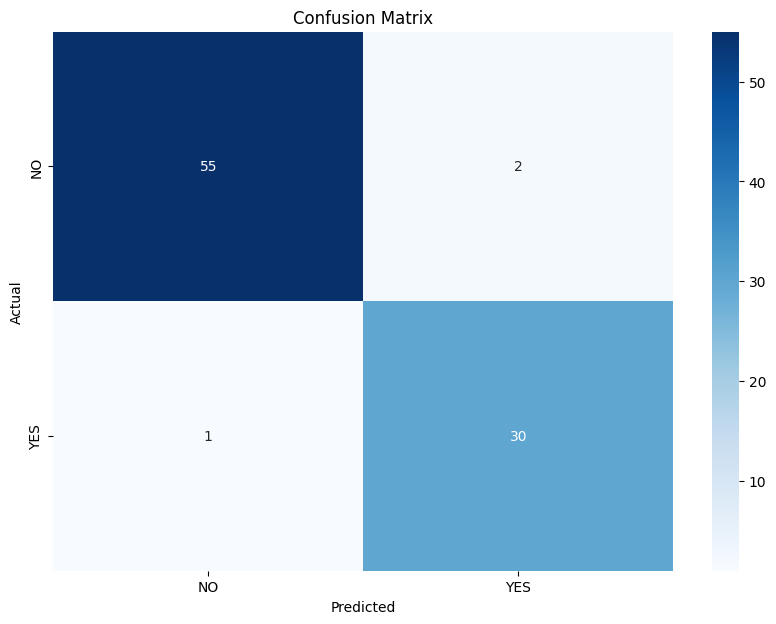

In [ ]:
#metrics
from fastai.tabular.all import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


preds, targs = learn.get_preds()


pred_labels = preds.argmax(dim=1)
#accuracy
accuracy = accuracy_score(targs, pred_labels)
print(f'Accuracy: {accuracy:.4f}')

#classification report
report = classification_report(targs, pred_labels, target_names=learn.dls.vocab)
print('Classification Report:')
print(report)
#generate confusion matrix
cm = confusion_matrix(targs, pred_labels)
print('Confusion Matrix:')
print(cm)

#Plot confusin matix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=learn.dls.vocab, yticklabels=learn.dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# feature importance for 2k rows

dl = learn.dls.test_dl(df, bs=256)


In [ ]:
feature_importances = tabnet_feature_importances(learn.model, dl)

In [ ]:
dl = learn.dls.test_dl(df.iloc[:20], bs=20)

In [ ]:
res_explain, res_masks = tabnet_explain(learn.model, dl)

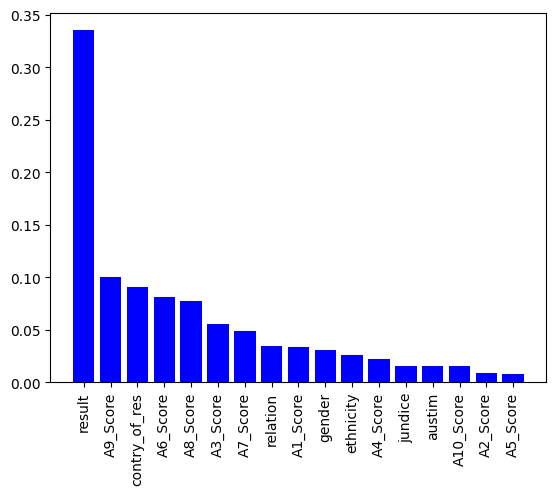

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming dl.x_names and feature_importances are lists or numpy arrays
x_names = np.array(dl.x_names)
feature_importances = np.array(feature_importances)

# Sorting the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
x_names_sorted = x_names[sorted_indices]
feature_importances_sorted = feature_importances[sorted_indices]

# Plotting the sorted feature importances
plt.xticks(rotation='vertical')
plt.bar(x_names_sorted, feature_importances_sorted, color='b')
plt.show()



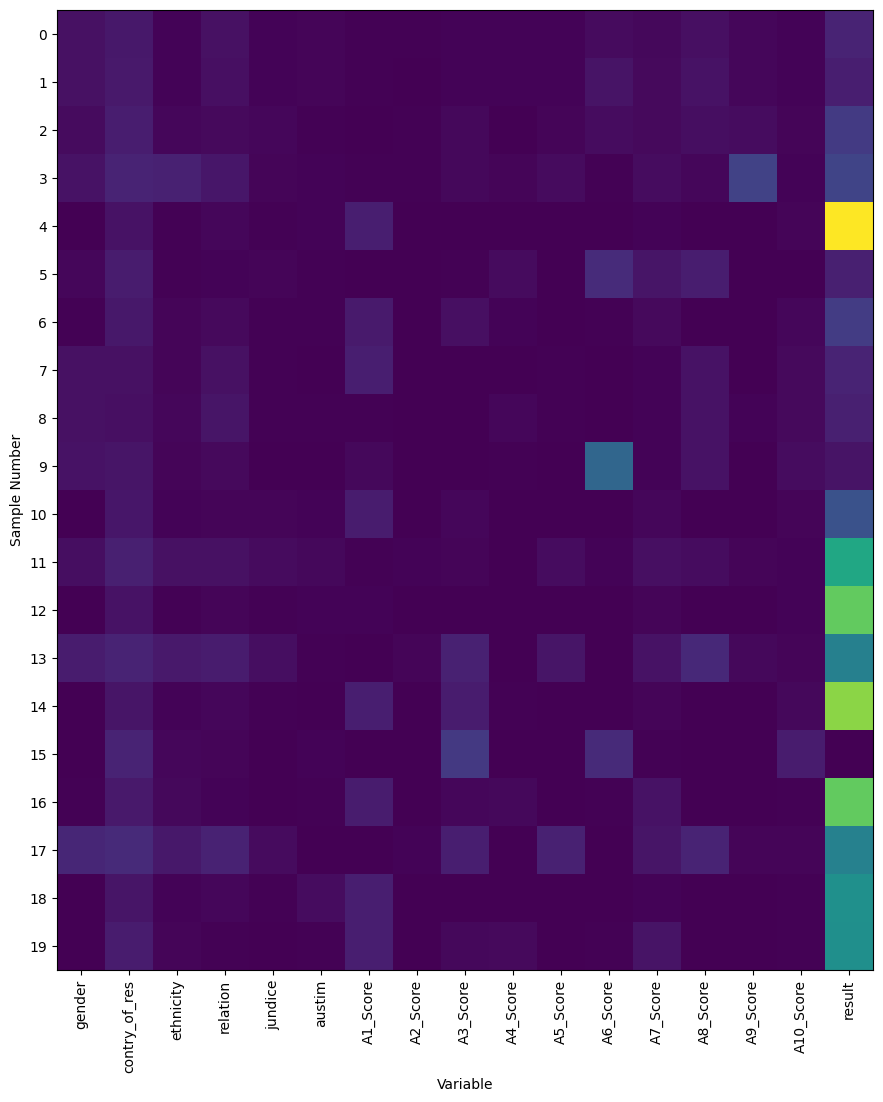

In [ ]:
def plot_explain(masks, lbls, figsize=(12,12)):
    "Plots masks with `lbls` (`dls.x_names`)"
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.yticks(np.arange(0, len(masks), 1.0))
    plt.xticks(np.arange(0, len(masks[0]), 1.0))
    ax.set_xticklabels(lbls, rotation=90)
    plt.ylabel('Sample Number')
    plt.xlabel('Variable')
    plt.imshow(masks)
plot_explain(res_explain, dl.x_names)

In [ ]:
preds,targs=learn.get_preds()
test=pd.read_csv('/content/autism_final - Sheet1.csv')
test.head()


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,...,m,Others,no,no,Jordan,no,5,4-11 years',Parent,NO
1,1,1,0,0,1,1,0,1,0,0,...,m,Middle Eastern ',no,no,Jordan,no,5,4-11 years',Parent,NO
2,1,1,0,0,0,1,1,1,0,0,...,m,?,no,no,Jordan,yes,5,4-11 years',?,NO
3,0,1,0,0,1,1,0,0,0,1,...,f,?,yes,no,Jordan,no,4,4-11 years',?,NO
4,1,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States',no,10,4-11 years',Parent,YES


In [ ]:
test_dl = dls.test_dl(test)

preds, _ = learn.get_preds(dl=test_dl)

# Add predictions to the test dataframe
test['predicted_result'] = preds.argmax(dim=1).numpy()

# Save the predictions to a CSV file
test.to_csv('sample_submission.csv', index=False)

print("Predictions saved to 'sample_submission.csv'.")

Predictions saved to 'sample_submission.csv'.


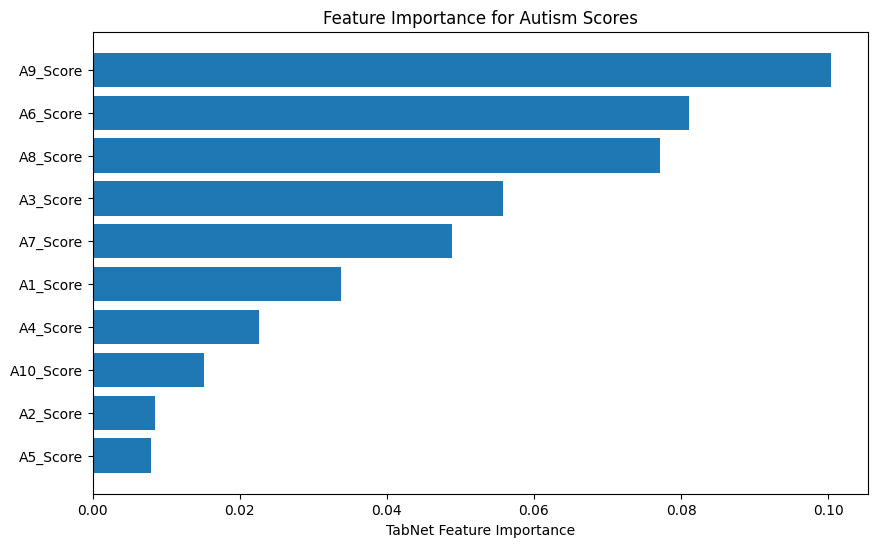

In [ ]:
autism_score_features = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
                         'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

# Assuming your feature names are stored in a list `feature_names`
feature_names = dls.train.xs.columns.tolist()

# Create a mask for the autism score features
autism_feature_mask = [feature in autism_score_features for feature in feature_names]

# Filter feature importance for autism score features
autism_feature_importances = feature_importances[autism_feature_mask]
autism_feature_names = np.array(feature_names)[autism_feature_mask]

# Sort the filtered feature importance
sorted_idx = np.argsort(autism_feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(autism_feature_names[sorted_idx], autism_feature_importances[sorted_idx])
plt.xlabel("TabNet Feature Importance")
plt.title("Feature Importance for Autism Scores")
plt.show()

In [ ]:
learn.export('model.pkl')